<a href="https://colab.research.google.com/github/ekmorozova111/26-Detection-object-recognition/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Данный ноутбук создан для выполнения чейкпонта N3**

Я выбрала следующие метрики, так как они больше всего подходят для обучения нашей модели:
Box(P, R, mAP50, mAP50-95) - метрика позволяет оценить эффективность модели в обнаружении объектов:

P (Precision) (Точность) -  метрика позволяет определить точность обнаруженных объектов, показывающая, сколько обнаружений было правильным.

R (Recall) (Полнота) - метрика которая показывает способность модели идентифицировать все виды объектов на изображениях.

mAP50: Средняя точность (mean average precision) - метрика рассчитанная при пороге Intersection over Union (IoU) 0.50 (пересечение через объединение). Это мера точности модели, учитывающая только "легкие" обнаружения.

mAP50-95: - метрика показывающая среднее значение средней точности, рассчитанное при различных порогах IoU в диапазоне от 0.50 до 0.95. Это дает полное представление об эффективности модели на разных уровнях сложности обнаружения.

**Для начала я загрузила датасет на платформу Kaggle и затем проведу файн-тюнинг предобученной модели yolov8s. Данная модель обучена на датасете СОСО (Common Objects in Context) - https://cocodataset.org/#home**

In [ ]:
# Установим библиотеку УльтраЛитикс в которой есть возможность файнтюнинга модели Йола
!pip install -q ultralytics "opencv-python<4.11"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curr

In [ ]:
# Импортируем необходимые библиотеки
import random
from glob import glob
import cv2
from PIL import Image
import glob

import shutil
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Начнем обучение модели, в файле конфигурации к датасету содержится необходимые пути
# к папкам с лейблами и изображениями и наименования классов
# В библиотеке УльтраЛитикс есть необходимый функционал для считывания файла конфигурации и проведения обучения

model = YOLO("yolov8s.pt")  # загрузим предобученную модель

# обучение модели, для начала попробуем провести обучение на 20 эпох
# обучение проведем на видеокарте, которая нам доступна
results = model.train(data="/kaggle/input/gun-dataset/gun_dataset/data.yaml", epochs=20, device=[0])

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/gun-dataset/gun_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3784       4695       0.89      0.854      0.917      0.724
               Handgun       1746       2156      0.893      0.861      0.932       0.78
                 Rifle       2069       2539      0.886      0.846      0.902      0.668
Speed: 0.2ms preprocess, 4.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


** В результате обучения мы получили обученную модель, теперь проверим ее на фотографиях из теста **


image 1/1 /kaggle/input/gun-dataset/gun_dataset/test/images/PistolGallery1018_jpeg.rf.4efcdc510d7b6d5a533a7a1ddc770816.jpg: 640x640 2 Handguns, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


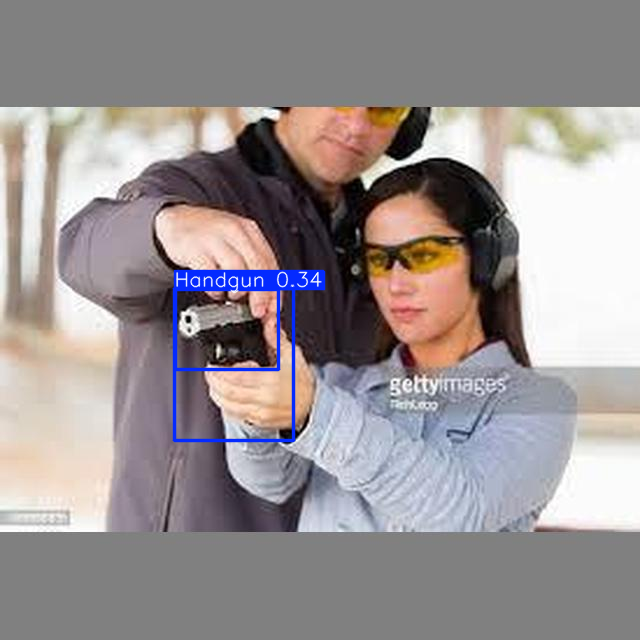

In [ ]:
# загрузим нашу обученную модель
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# проведем инференс на изображении с пистолетом
results = model('/kaggle/input/gun-dataset/gun_dataset/test/images/PistolGallery1018_jpeg.rf.4efcdc510d7b6d5a533a7a1ddc770816.jpg')

# обработка результатов
for r in results:
    boxes = r.boxes  # бибоксы
    # отобразим изображение с бибоксом
    r.show()

**как мы видим пистолеты детектятся не очень хорошо, в дальнейшем будем работать над этой проблемой**


image 1/1 /kaggle/input/gun-dataset/gun_dataset/test/images/PeoplearmedwithRevolvers279_jpeg.rf.10b96326fb7a3d3a97e4c5cc64321356.jpg: 640x640 1 Rifle, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


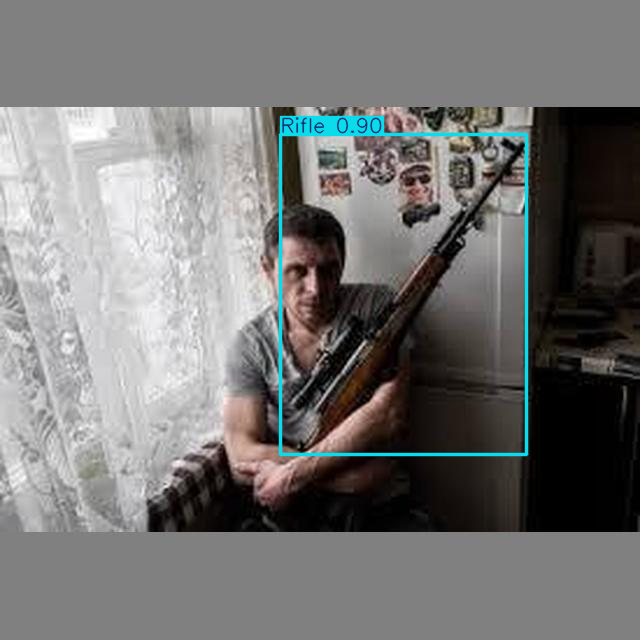

In [ ]:
# проведем инференс на изображении с винтовкой
results = model('/kaggle/input/gun-dataset/gun_dataset/test/images/PeoplearmedwithRevolvers279_jpeg.rf.10b96326fb7a3d3a97e4c5cc64321356.jpg')

# обработка результатов
for r in results:
    boxes = r.boxes  # бибоксы
    # отобразим изображение с бибоксом
    r.show()

**Винтовки детектятся лучше**

**Покажем процесс и результаты обучения**

In [ ]:
import glob
import os

# путь к папке с результатами
results_dir = '/kaggle/working/runs/detect/train'

# List some files to confirm the path is correct
if os.path.exists(results_dir):
    print(f"Found results directory: {results_dir}")
    print("Files inside:", os.listdir(results_dir)[:5]) # Print first 5 items
else:
    print(f"Directory not found: {results_dir}")

Found results directory: /kaggle/working/runs/detect/train
Files inside: ['train_batch0.jpg', 'val_batch0_pred.jpg', 'train_batch7810.jpg', 'val_batch2_pred.jpg', 'BoxR_curve.png']


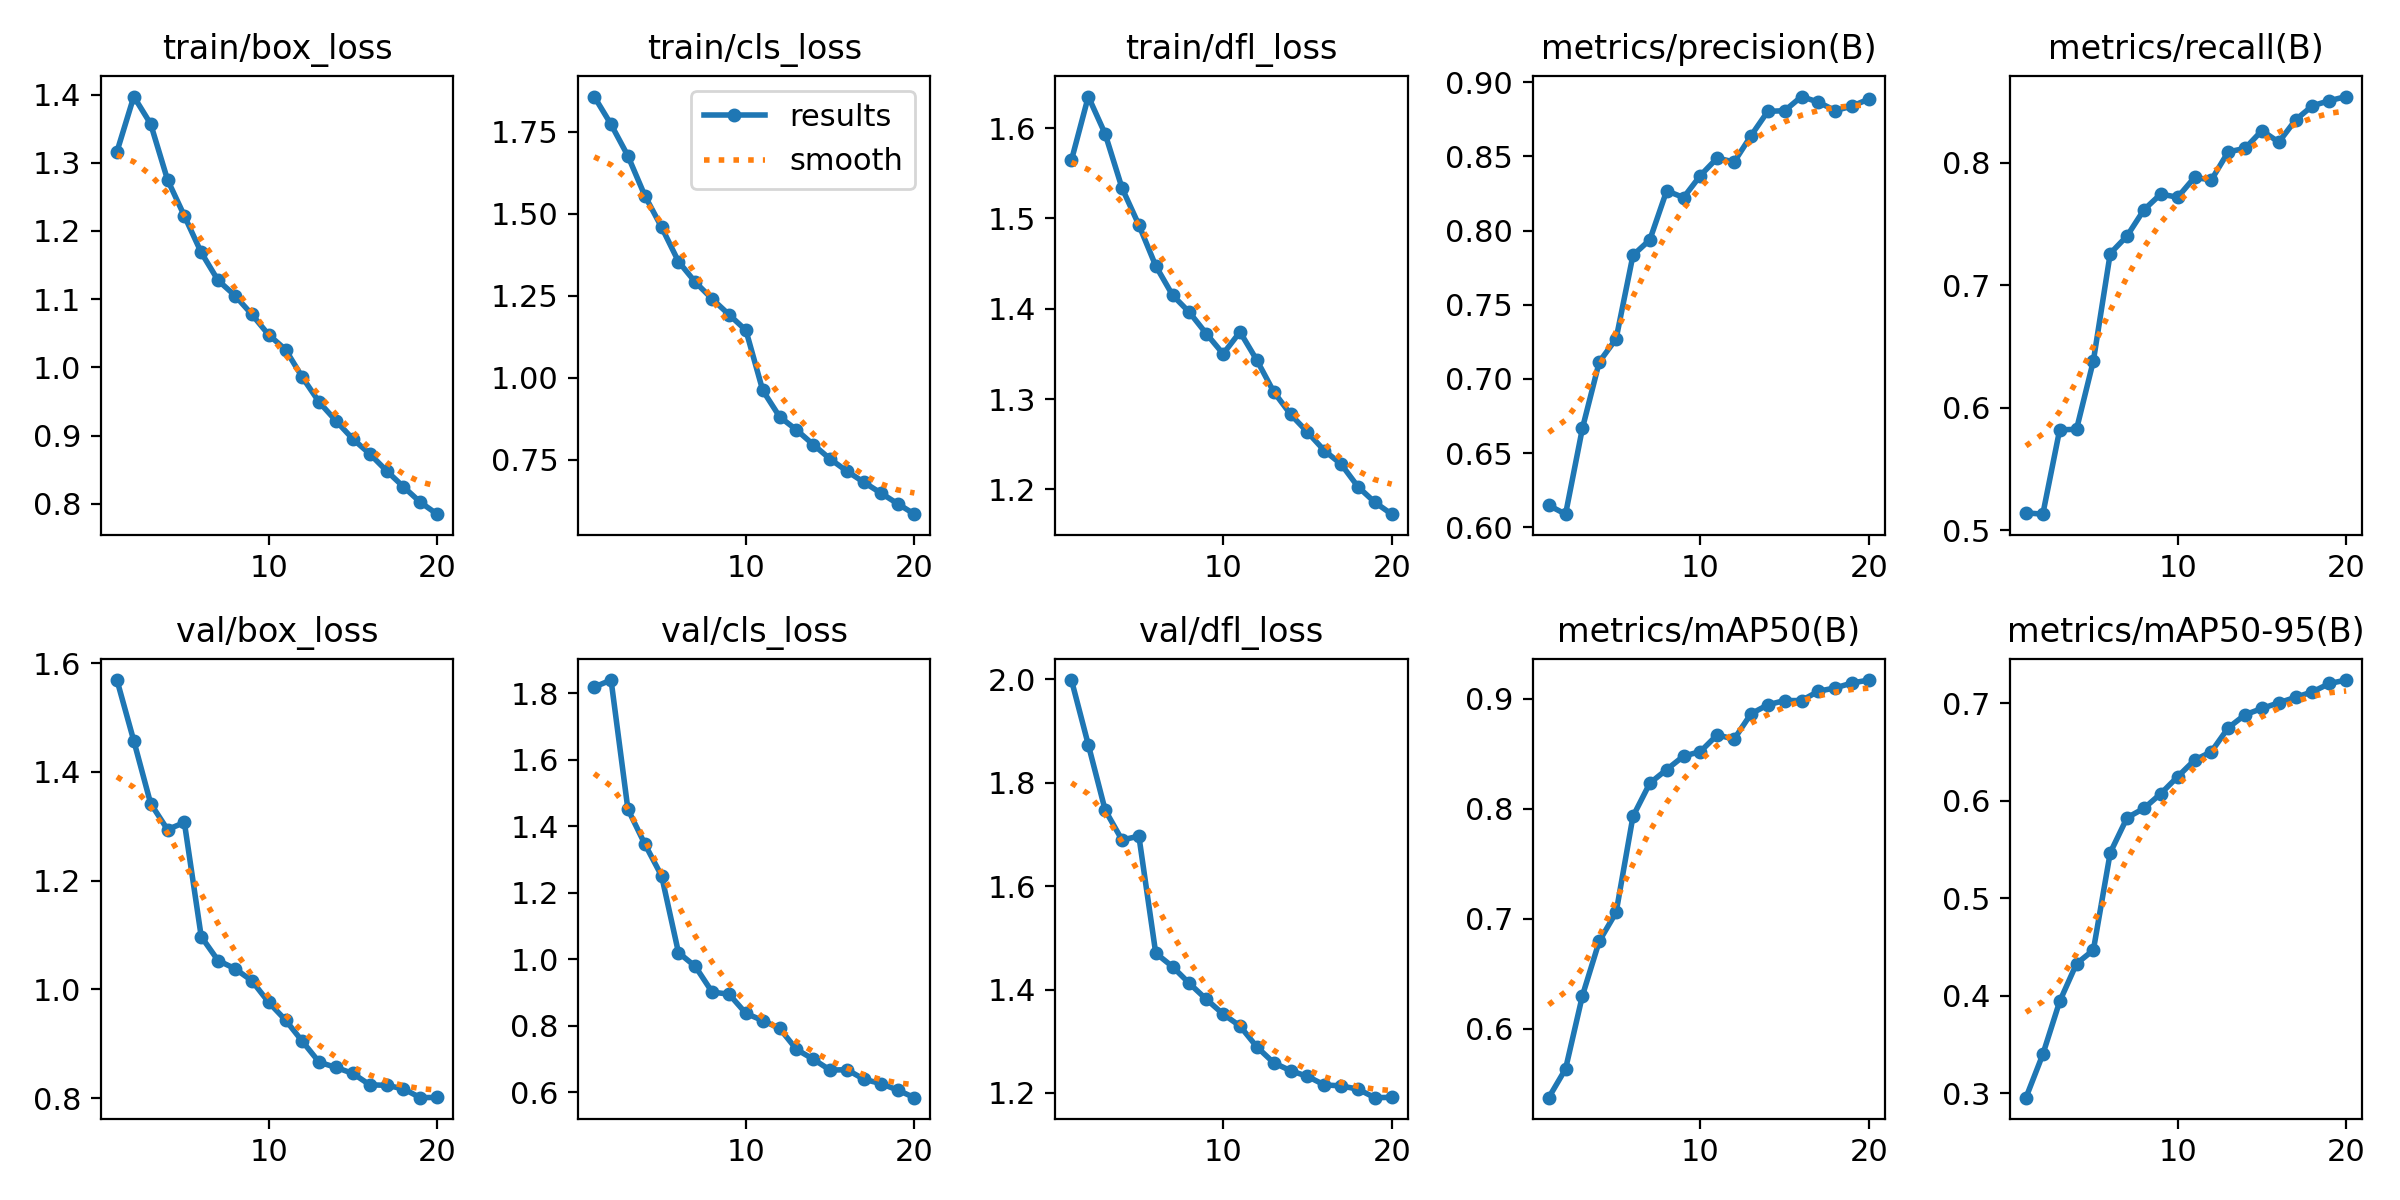

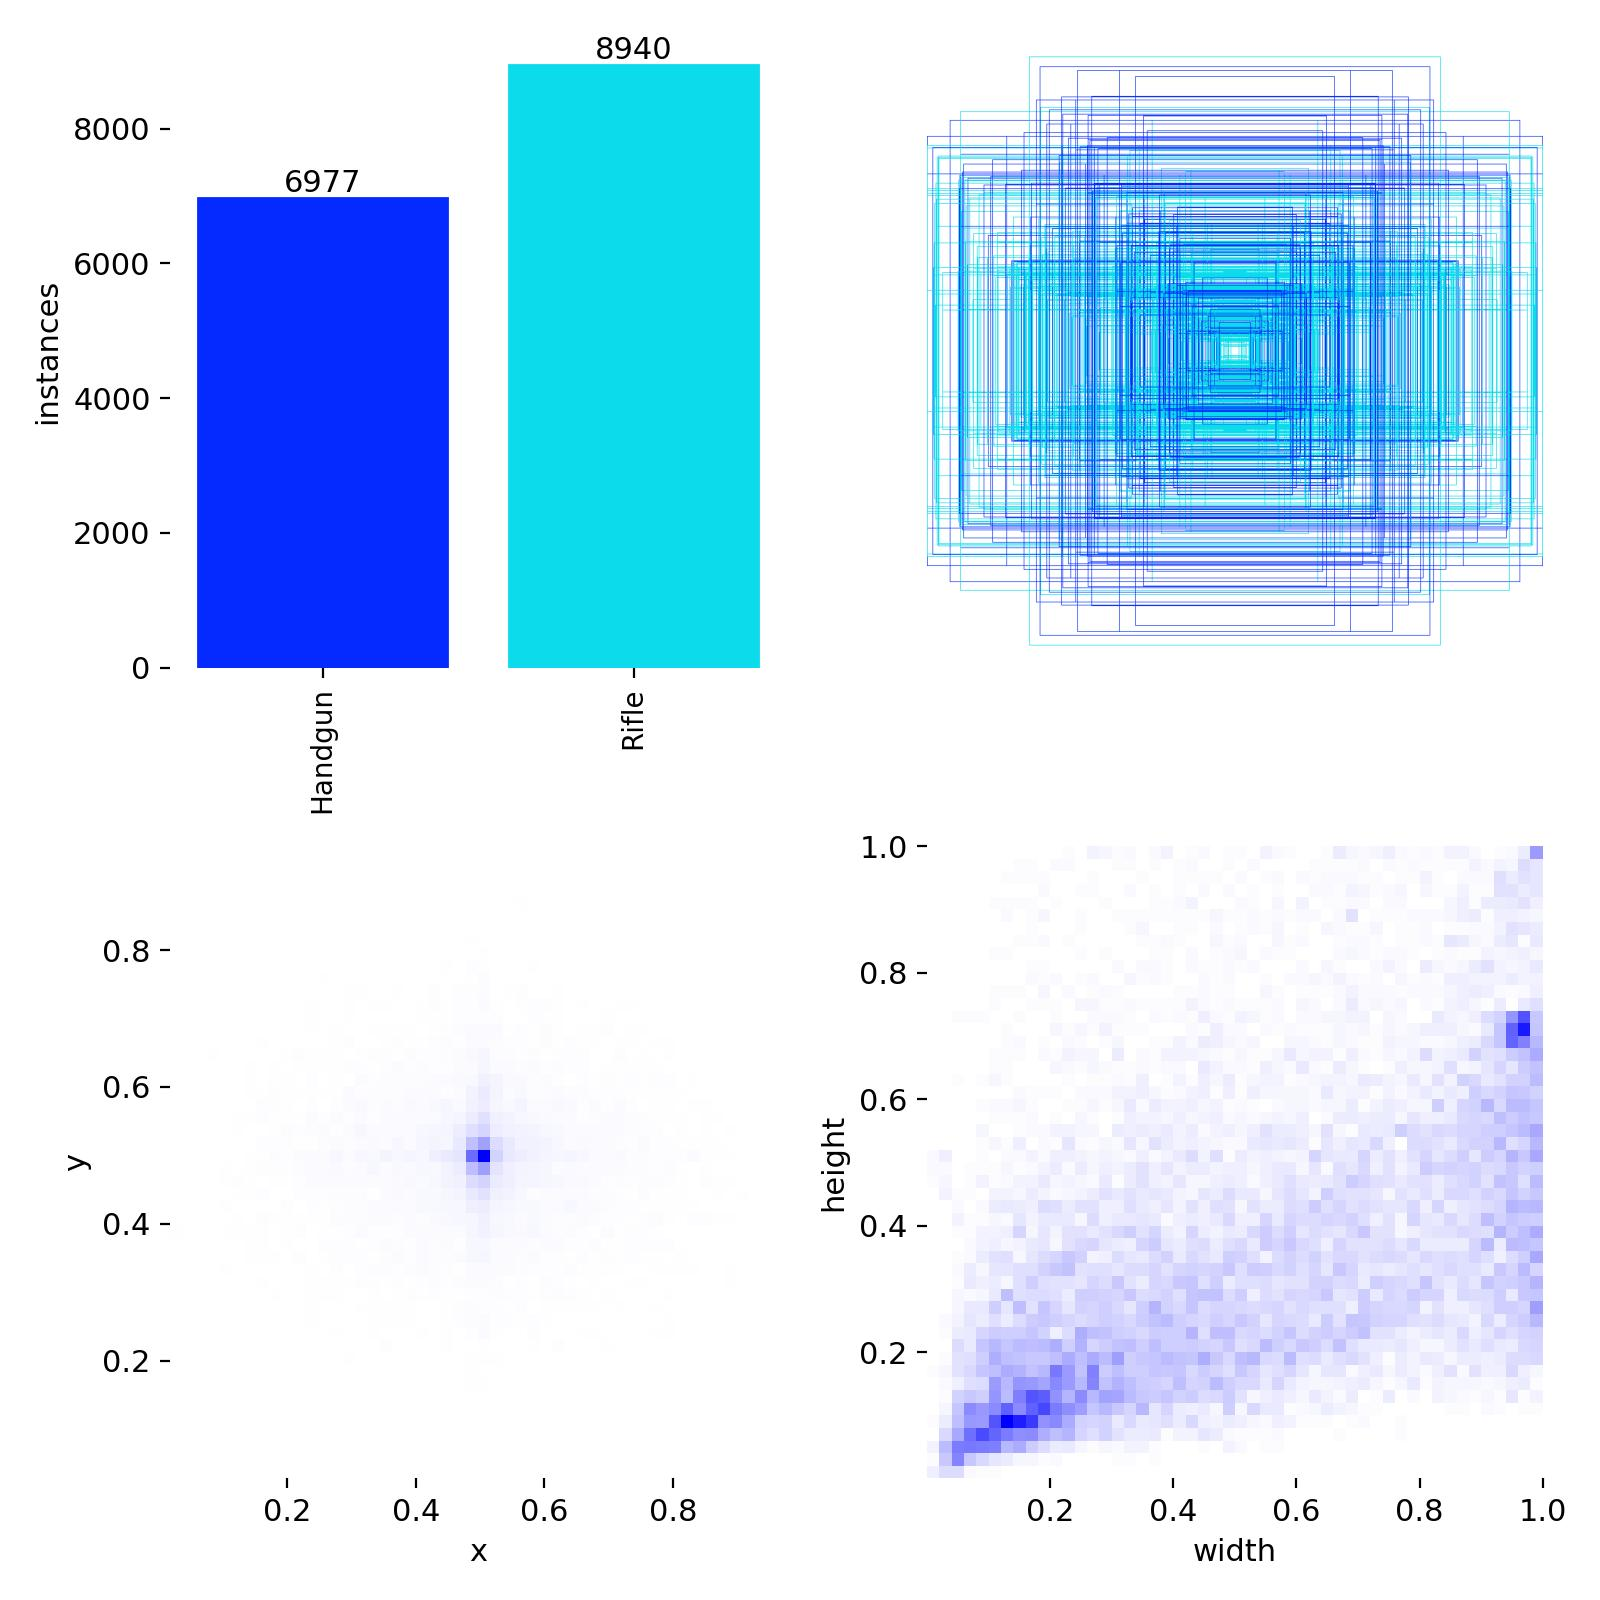

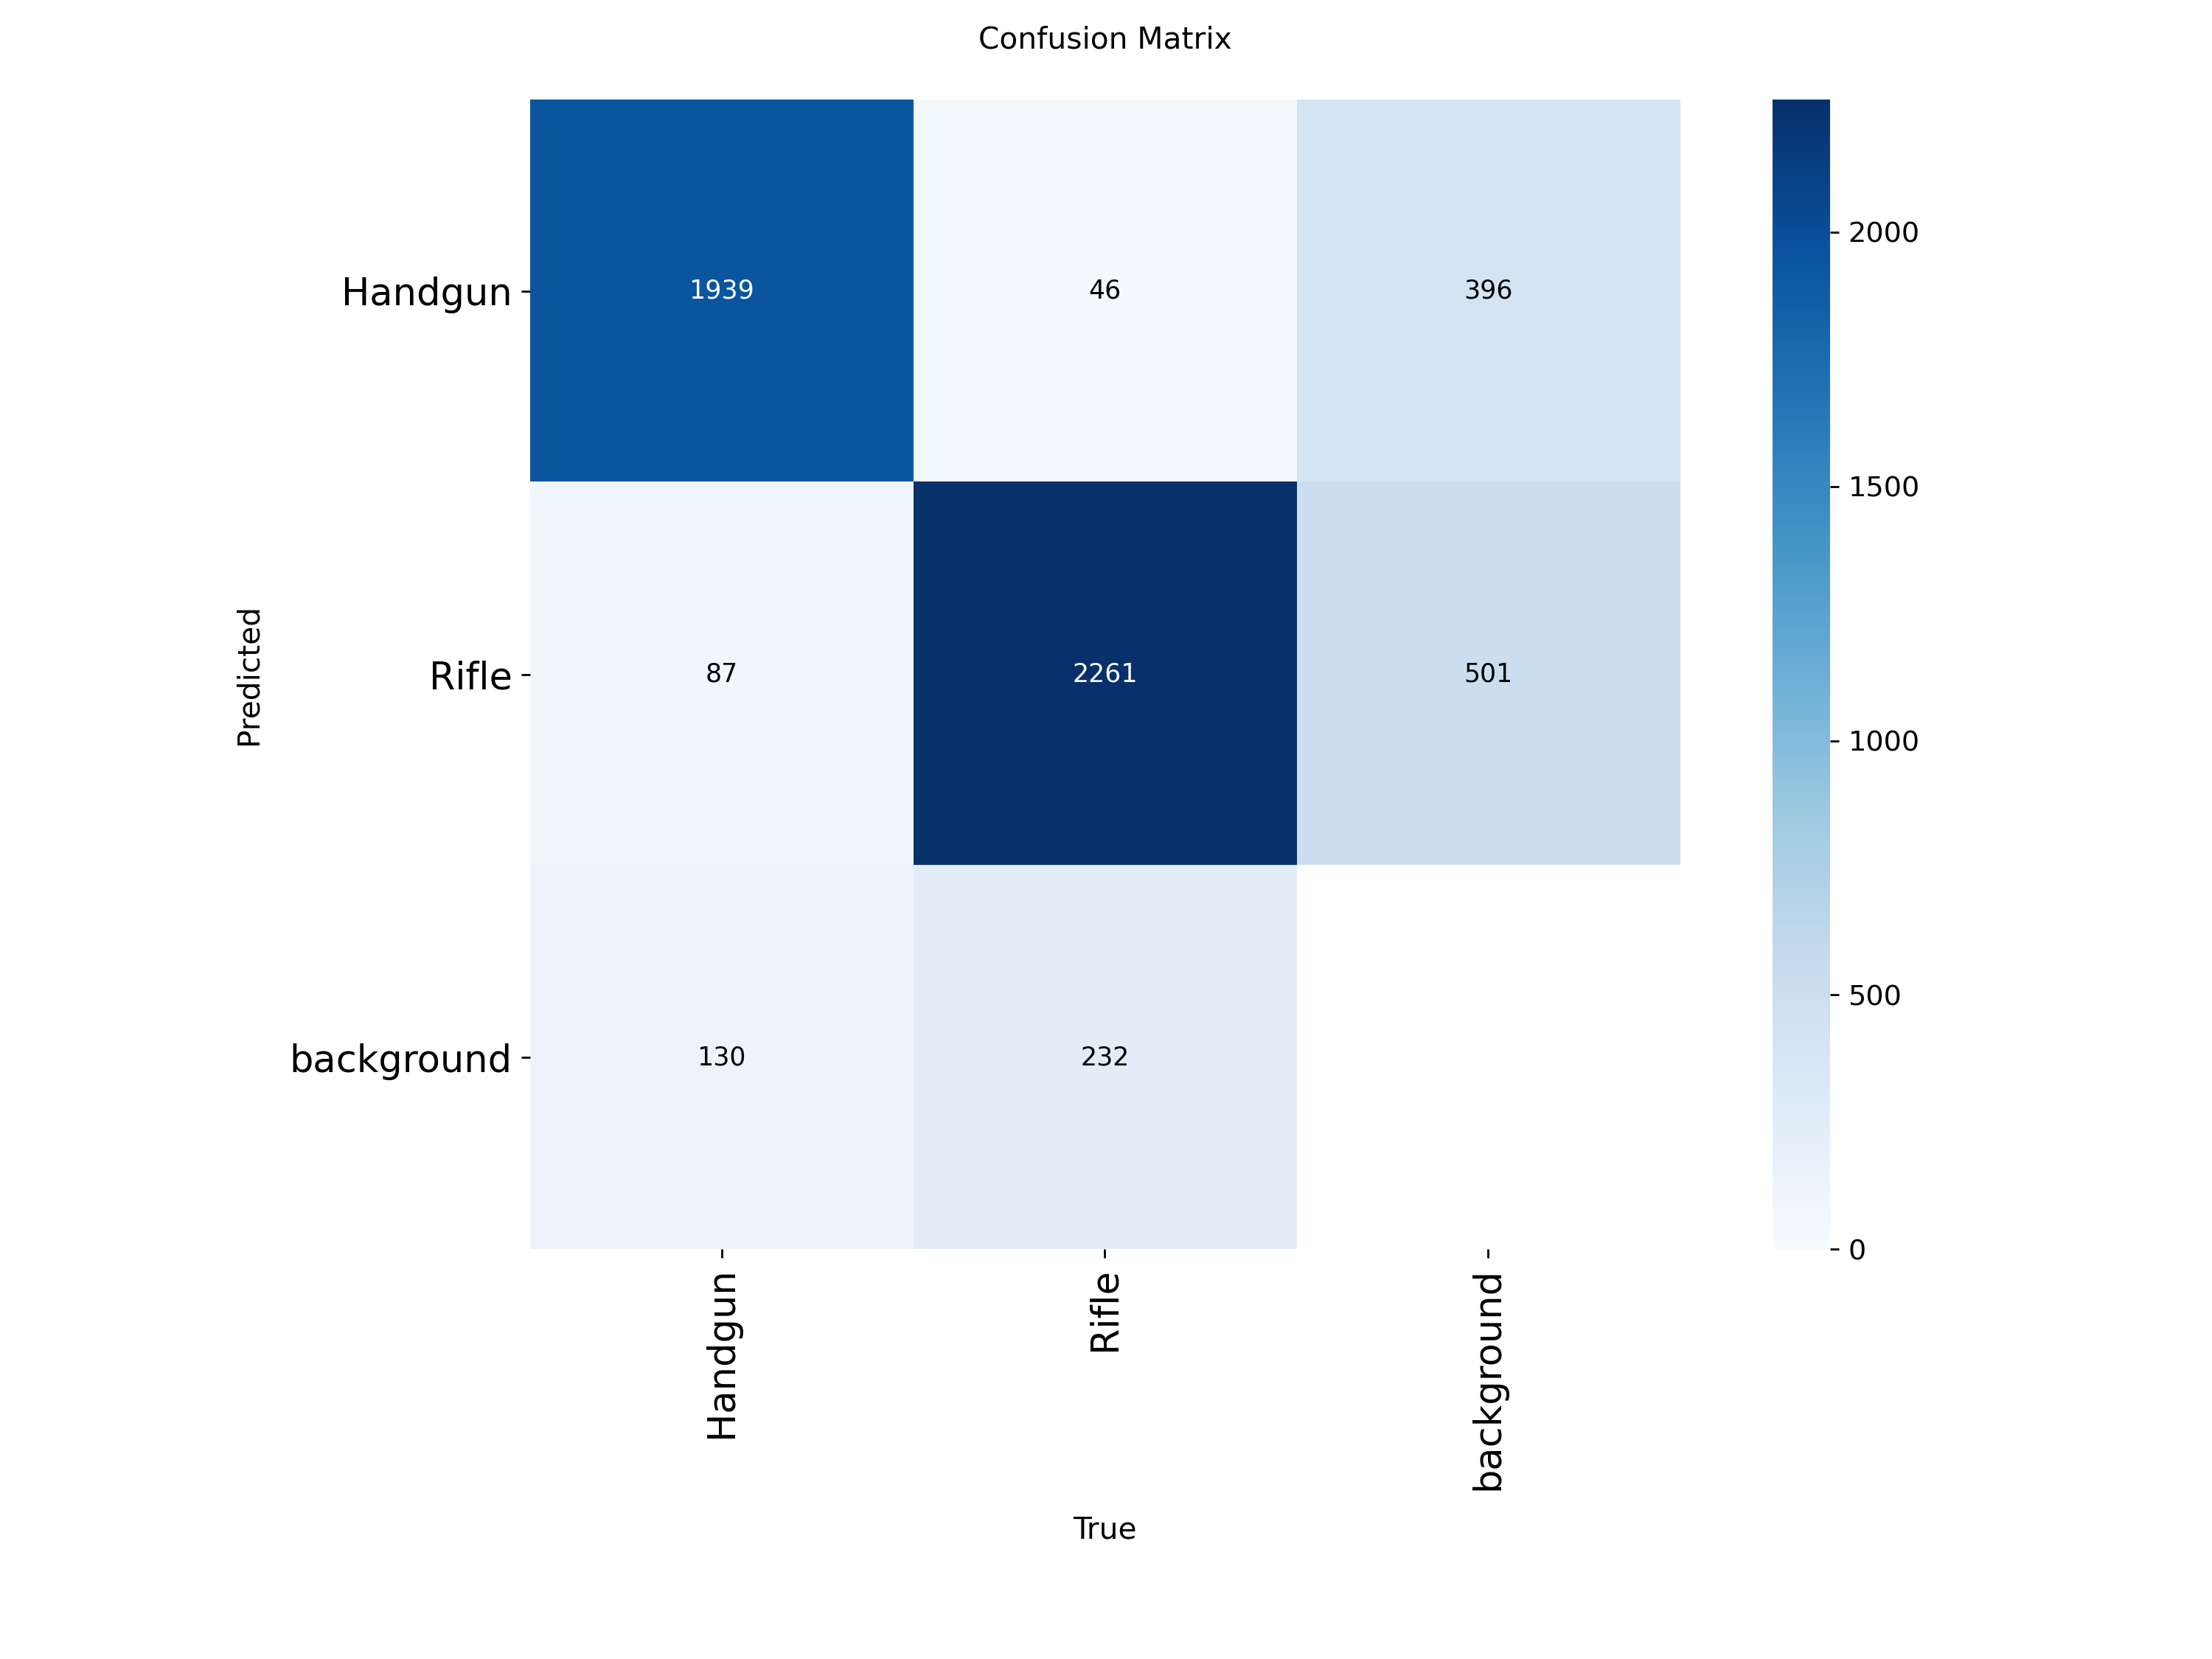

In [ ]:
from IPython.display import Image, display

# Display the main results plot
display(Image(filename=f'{results_dir}/results.png', width=800))

# Display dataset labels/stats
display(Image(filename=f'{results_dir}/labels.jpg', width=800))

# Display confusion matrix (if available)
display(Image(filename=f'{results_dir}/confusion_matrix.png', width=800))

Found 6 training batch images. Displaying the first 3:


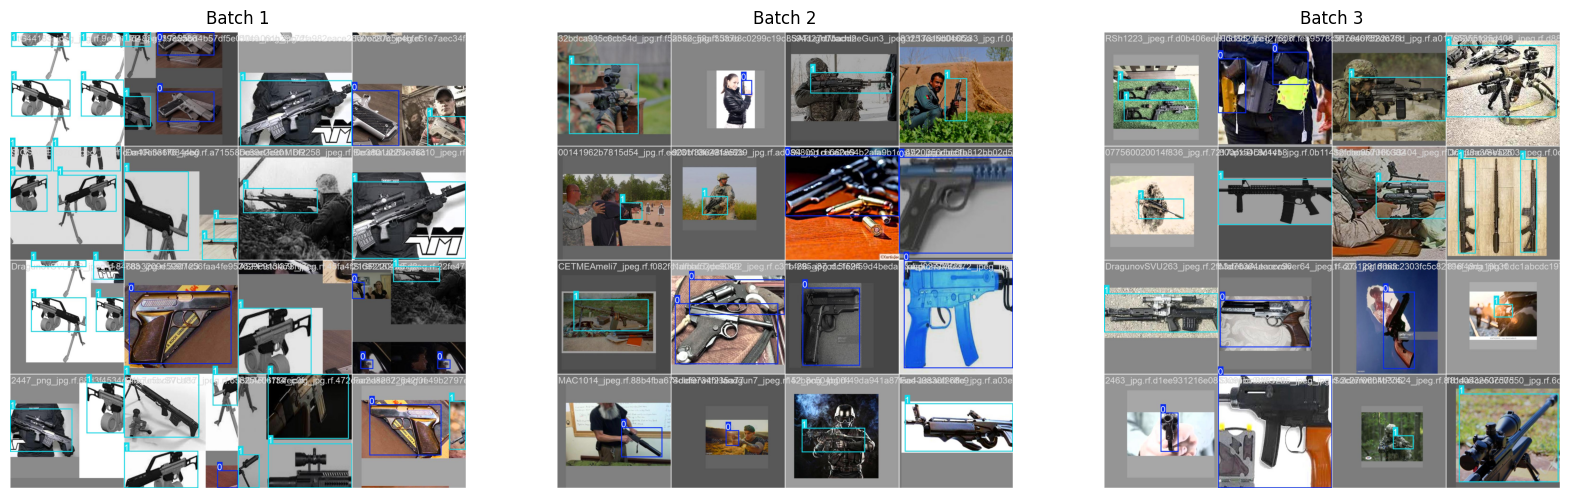

In [ ]:
import matplotlib.pyplot as plt
import cv2
import glob

# Get a list of all training batch images
train_images = glob.glob(f'{results_dir}/train_batch*.jpg')

print(f"Found {len(train_images)} training batch images. Displaying the first 3:")

# Display the first few images using Matplotlib
plt.figure(figsize=(20, 15))
for i, img_path in enumerate(train_images[:3]):
    img = cv2.imread(img_path)
    # OpenCV loads in BGR, Matplotlib expects RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Batch {i+1}")
    plt.axis('off')

plt.show()